In [1]:
import os
import sys
import requests

module_path=os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import pyproj
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as colors
import plotly
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go


%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# US COVID-19 Case Data Visualisation
## Procedure 1: US States and Counties GeoDataFrame (EPSG: 2163)
### US State - `us_states_gdf`

In [2]:
# Read US States Boundary Shapefile
us_states_gdf = gpd.read_file('Data/input/us_state/cb_2018_us_state_5m.shp')

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_states_gdf.to_crs(epsg=2163, inplace=True)

# Adding a column 'coords' for later use (labeling each State)
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
us_states_gdf['coords'] = us_states_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
us_states_gdf['coords'] = [coords[0] for coords in us_states_gdf['coords']]

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



There are US States/Territories that I don't want to include for data mapping purposes. They are Palau (PW/70), Guam (GU/66), Northern Mariana Islands (MP/69), American Samoa (AS/60), Hawaii (HI/15), Puerto Rico (PR/72), and Virgin Islnads (VI/78).

In [3]:
us_states_gdf = us_states_gdf[
    (us_states_gdf['STATEFP'] != '70') &
    (us_states_gdf['STATEFP'] != '66') &
    (us_states_gdf['STATEFP'] != '69') &
    (us_states_gdf['STATEFP'] != '60') &
    (us_states_gdf['STATEFP'] != '15') &
    (us_states_gdf['STATEFP'] != '72') &
    (us_states_gdf['STATEFP'] != '78')
]

### US County - `us_counties_gdf`

In [4]:
# Read US Counties Boundary Shapefile
us_counties_gdf = gpd.read_file('Data/input/us_counties/cb_2018_us_county_5m.shp')

# Adding a 'FULLFP' column that concatenates 'STATEFP' and 'COUNTYFP'
us_counties_gdf['FULLFP'] = us_counties_gdf['STATEFP'] + us_counties_gdf['COUNTYFP']

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_counties_gdf.to_crs(epsg=2163, inplace=True)

# us_counties_gdf is missing the post code (stusps), therefore, merging it with fips_df
# Read US State Name, FIPS, and Postcode csv file 
fips_csv_dir = 'Data/input/us_state_fips/us-state-ansi-fips.csv'
fips_df = pd.read_csv(fips_csv_dir, dtype={' fips':object})

# Rename columns
fips_df.rename(columns=
    {' fips': 'fips',
    ' stusps': 'postcode',},
    inplace=True)

# Attribute Joins - Merging `us_counties_gdf` and `fips_df` on `'STATEFP'` and `'fips'`
merged_df = pd.merge(
    left=us_counties_gdf, 
    right=fips_df, 
    how='left', 
    left_on='STATEFP', 
    right_on='fips'
)

# Remove (drop) 'fips' column
merged_df = merged_df.drop(['fips'], axis=1)

# Make us_gdf a GeoDataFrame of merged_df
us_counties_gdf = gpd.GeoDataFrame(merged_df,
                                   crs={'init': 'epsg:2163'},
                                   geometry=merged_df['geometry'])

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



## Procedure 2: US COVID-19 Cases/Deaths/Testing DataFrame

### [Our World in Data](https://ourworldindata.org/coronavirus)

In [5]:
fields = ['iso_code', 'location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_cases_per_million', 'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'total_tests', 'new_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'tests_units', 'population', 'population_density',]
owid_complete_df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', usecols=fields)
owid_complete_df = owid_complete_df[
    (owid_complete_df['location']=='United States') | 
    (owid_complete_df['location']=='South Korea')
]

owid_complete_df['datetime']=pd.to_datetime(owid_complete_df['date'])

# US OWID Data
owid_us_df = owid_complete_df[owid_complete_df['iso_code']=='USA']
owid_us_df['datetime'] = pd.to_datetime(owid_us_df['date'])
owid_us_plot_df = owid_us_df.copy()
owid_us_plot_df.set_index('datetime', inplace=True)

# KOR OWID Data
owid_kor_df = owid_complete_df[owid_complete_df['iso_code']=='KOR']
owid_kor_df['datetime'] = pd.to_datetime(owid_kor_df['date'])
owid_kor_plot_df = owid_kor_df.copy()
owid_kor_plot_df.set_index('datetime', inplace=True)

### [New York Times US County Data](https://github.com/nytimes/covid-19-data)

In [6]:
# Read NYTimes COVID-19 US County Data
nytimes_counties_url='https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
nytimes_counties_df = pd.read_csv(nytimes_counties_url)

# Creating a 'datetime' column which is a datetime dtype of 'date'
nytimes_counties_df['datetime'] = pd.to_datetime(nytimes_counties_df['date'])

### [Johns Hopkins Uni & Med for US Accumulative County Data](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

In [7]:
# Read JHU COVID-19 US County Data
jhu_county_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
jhu_county_df = pd.read_csv(jhu_county_url)

# Deleting unnecessary columns
jhu_county_df.drop(['UID', 'iso2', 'iso3', 'code3', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis=1, inplace=True)

#### Fixing issues with NaN FIPS in the `jhu_county_df`

In [8]:
missing_idx = jhu_county_df[
    (jhu_county_df['Admin2']=='Central Utah') | \
    (jhu_county_df['Admin2']=='Southeast Utah') | \
    (jhu_county_df['Admin2']=='Southwest Utah') | \
    (jhu_county_df['Admin2']=='TriCounty') | \
    (jhu_county_df['Admin2']=='Michigan Department of Corrections (MDOC)') | \
    (jhu_county_df['Admin2']=='Federal Correctional Institution (FCI)') | \
    ((jhu_county_df['Admin2']=='Morgan') & (jhu_county_df['Province_State']=='Utah')) | \
    ((jhu_county_df['Admin2']=='Rich') & (jhu_county_df['Province_State']=='Utah')) | \
    (jhu_county_df['Admin2']=='Cache') | \
    ((jhu_county_df['Admin2']=='Beaver') & (jhu_county_df['Province_State']=='Utah')) | \
    (jhu_county_df['Admin2']=='Millard') | \
    ((jhu_county_df['Admin2']=='Iron') & (jhu_county_df['Province_State']=='Utah')) | \
    (jhu_county_df['Admin2']=='Uintah)') | \
    ((jhu_county_df['Admin2']=='Garfield') & (jhu_county_df['Province_State']=='Utah')) | \
    ((jhu_county_df['Admin2']=='Kane') & (jhu_county_df['Province_State']=='Utah')) | \
    ((jhu_county_df['Admin2']=='Carbon') & (jhu_county_df['Province_State']=='Utah')) | \
    ((jhu_county_df['Admin2']=='Washington') & (jhu_county_df['Province_State']=='Utah')) | \
    (jhu_county_df['Admin2']=='Duchesne') | \
    (jhu_county_df['Admin2']=='Emery') | \
    ((jhu_county_df['Admin2']=='Grand') & (jhu_county_df['Province_State']=='Utah')) | \
    (jhu_county_df['Admin2']=='Juab') | \
    ((jhu_county_df['Admin2']=='Sevier') & (jhu_county_df['Province_State']=='Utah')) | \
    (jhu_county_df['Admin2']=='Sanpete') | \
    ((jhu_county_df['Admin2']=='Piute') & (jhu_county_df['Province_State']=='Utah')) | \
    ((jhu_county_df['Admin2']=='Wayne') & (jhu_county_df['Province_State']=='Utah')) | \
    ((jhu_county_df['Admin2']=='Beaver') & (jhu_county_df['Province_State']=='Utah')) | \
    (jhu_county_df['Admin2']=='Daggett')
].index

jhu_county_df.drop(missing_idx, inplace=True)

for i in jhu_county_df.index:
    if jhu_county_df.loc[i, 'Admin2']=='Dukes and Nantucket':
        jhu_county_df.at[i, 'FIPS']='25019'
        
    elif jhu_county_df.loc[i, 'Admin2']=='Weber-Morgan':
        jhu_county_df.at[i, 'FIPS']='49057'

    elif jhu_county_df.loc[i, 'Admin2']=='Bear River':
        jhu_county_df.at[i, 'FIPS']='49003'

    elif jhu_county_df.loc[i, 'Admin2']=='Kansas City':
        jhu_county_df.at[i, 'FIPS']='29095'

#### Converting individual date colums into rows (melting dataframe) ([Ref](https://stackoverflow.com/questions/28654047/pandas-convert-some-columns-into-rows))

In [9]:
jhu_county_df = jhu_county_df.melt(id_vars=['Admin2', 'Province_State', 'FIPS'],
                                    var_name='Date',
                                    value_name='Cases')

jhu_county_df['FIPS'] = jhu_county_df['FIPS'].astype(int).astype(object)
jhu_county_df['datetime'] =pd.to_datetime(jhu_county_df['Date'].astype(str), format='%m/%d/%y')
jhu_county_df['datetime']=pd.to_datetime(jhu_county_df['datetime'])

#### Modifying NYC Counties Data because all NYC counties data is aggregated under 'New York' only and not the rest boroughs.
#### First, drop NYC counties from the jhu_county_df.  Then, merge it with [the City Project]( https://projects.thecity.nyc/2020_03_covid-19-tracker/) Data 

In [10]:
nyc_idx = jhu_county_df.index[
    (jhu_county_df['Admin2'] == 'Bronx') | \
    ((jhu_county_df['Admin2'] == 'Kings') & (jhu_county_df['Province_State'] == 'New York')) | \
    (jhu_county_df['Admin2'] == 'New York') | \
    (jhu_county_df['Admin2']=='Queens') | \
    ((jhu_county_df['Admin2'] == 'Richmond') & (jhu_county_df['Province_State'] == 'New York'))
].tolist()

jhu_county_df.drop(nyc_idx, inplace=True)

In [11]:
thecity_df = pd.read_csv('https://raw.githubusercontent.com/thecityny/covid-19-nyc-data/master/borough.csv')

thecity_df.rename(columns={'timestamp': 'date',
                           'bronx': 'Bronx',
                           'brooklyn': 'Kings',
                           'queens': 'Queens',
                           'manhattan': 'New York',
                           'staten_island': 'Richmond'},
                  inplace=True)

# Adding Unknown Bourugh Cases to Queens (my choice)
thecity_df['New York'] = thecity_df['Queens'] + thecity_df['unknown']

# Converting 'date' to str without UTC timezone
thecity_df['date'] = pd.to_datetime(thecity_df['date'], infer_datetime_format = True).astype(str)
thecity_df['date'] = thecity_df['date'].str[:-9]

# Removing 'total' and 'unknown' columns
thecity_df.drop(['total', 'unknown'], inplace=True, axis=1)

# Creating a DataFrame that includes only confirmed cases, not deaths
thecity_cases_df = thecity_df[thecity_df['type']=='cases'].copy()
thecity_cases_df.drop('type', inplace=True, axis=1)

# Transposing the DataFrame to add 'FIPS', county name, and state name
thecity_cases_transposed_df = thecity_cases_df.set_index('date').transpose(copy=True).copy()
thecity_cases_transposed_df['FIPS'] = ['36005', '36047', '36061', '36081', '36085']
thecity_cases_transposed_df['Admin2'] = ['Bronx', 'Kings', 'New York', 'Queens', 'Richmond']
thecity_cases_transposed_df['Province_State'] = ['New York', 'New York','New York','New York','New York']

# Putting 'FIPS', 'Admin2', 'Province_State' columns to the front
thecity_cases_transposed_df = thecity_cases_transposed_df[['FIPS', 'Admin2', 'Province_State'] + [col for col in thecity_cases_transposed_df if col not in ['FIPS', 'Admin2', 'Province_State']]]
thecity_cases_transposed_df.reset_index(drop=True, inplace=True)
thecity_cases_transposed_df = thecity_cases_transposed_df.rename_axis(None)

# Melting the DataFrame so it's easier to merge with jhu_county_df
thecity_cases_df = thecity_cases_transposed_df.melt(id_vars=['FIPS', 'Admin2', 'Province_State'],
                                                    var_name='Date', value_name='Cases')

# Creating a 'datetime' column with dtype datetime64[ns]
thecity_cases_df['datetime']=pd.to_datetime(thecity_cases_df['Date'])

# pd.concat to jhu_county_df
jhu_county_df = pd.concat([jhu_county_df, thecity_cases_df.rename(columns={
    'Admin2': 'Admin2',
    'Province_State': 'Province_State',
    'FIPS': 'FIPS',
    'Date': 'Date',
    'Cases': 'Cases',
    'datetime': 'datetime',})], ignore_index=True)


#### Modifying Utah Counties Data because they are using 'Central', 'Southeast', 'Southwest', and 'TriCounty' instead of specific counties.  Going to `.concat` Utah County Data from NYTimes County Data

In [12]:
nytimes_counties_df.drop('deaths', inplace=True, axis=1)

missing_ut_county_df = nytimes_counties_df[
    ((nytimes_counties_df['county']=='Morgan') & (nytimes_counties_df['state']=='Utah')) | \
    ((nytimes_counties_df['county']=='Rich') & (nytimes_counties_df['state']=='Utah')) | \
    (nytimes_counties_df['county']=='Cache') | \
    ((nytimes_counties_df['county']=='Beaver') & (nytimes_counties_df['state']=='Utah')) | \
    (nytimes_counties_df['county']=='Millard') | \
    ((nytimes_counties_df['county']=='Iron') & (nytimes_counties_df['state']=='Utah')) | \
    (nytimes_counties_df['county']=='Uintah)') | \
    ((nytimes_counties_df['county']=='Garfield') & (nytimes_counties_df['state']=='Utah')) | \
    ((nytimes_counties_df['county']=='Kane') & (nytimes_counties_df['state']=='Utah')) | \
    ((nytimes_counties_df['county']=='Carbon') & (nytimes_counties_df['state']=='Utah')) | \
    ((nytimes_counties_df['county']=='Washington') & (nytimes_counties_df['state']=='Utah')) | \
    (nytimes_counties_df['county']=='Duchesne') | \
    (nytimes_counties_df['county']=='Emery') | \
    ((nytimes_counties_df['county']=='Grand') & (nytimes_counties_df['state']=='Utah')) | \
    (nytimes_counties_df['county']=='Juab') | \
    ((nytimes_counties_df['county']=='Sevier') & (nytimes_counties_df['state']=='Utah')) | \
    (nytimes_counties_df['county']=='Sanpete') | \
    ((nytimes_counties_df['county']=='Piute') & (nytimes_counties_df['state']=='Utah')) | \
    ((nytimes_counties_df['county']=='Wayne') & (nytimes_counties_df['state']=='Utah')) | \
    ((nytimes_counties_df['county']=='Beaver') & (nytimes_counties_df['state']=='Utah')) | \
    (nytimes_counties_df['county']=='Daggett')
]

jhu_county_df = pd.concat([jhu_county_df, missing_ut_county_df.rename(columns={
    'date': 'Date',
    'county': 'Admin2',
    'state': 'Province_State',
    'fips': 'FIPS',
    'cases': 'Cases',
    'datetime': 'datetime',})], ignore_index=True)

jhu_county_df = jhu_county_df.sort_values(by=['datetime'], ignore_index=True)

### [COVID Tracking Project Latest US & States Current Data](https://covidtracking.com/api)

In [13]:
# Read COVID Tracking Project US COVID-19 Current Data
ctp_us_now_df = pd.read_json('https://covidtracking.com/api/v1/us/current.json')[['positive', 'death', 'total']]

# Read COVID Tracking Project US States COVID-19 Current Data
ctp_states_now_df = pd.read_json('https://covidtracking.com/api/v1/states/current.json', dtype={'fips':object})[
    ['state', 'fips', 'positive', 'death', 'total']
]

# Removing Palau (PW/70), Guam (GU/66), Northern Mariana Islands (MP/69), American Samoa (AS/60), Hawaii (HI/15), Puerto Rico (PR/72), and Virgin Islnads (VI/78)
ctp_states_now_df = ctp_states_now_df[
    (ctp_states_now_df['fips'] != '70') &
    (ctp_states_now_df['fips'] != '66') &
    (ctp_states_now_df['fips'] != '69') &
    (ctp_states_now_df['fips'] != '60') &
    (ctp_states_now_df['fips'] != '15') &
    (ctp_states_now_df['fips'] != '72') &
    (ctp_states_now_df['fips'] != '78')
]

# Renaming the `total` to `test`
ctp_states_now_df.rename(columns = {'total': 'test'}, inplace=True,)

### [COVID Tracking Project US Accumulative Data](https://covidtracking.com/api)

In [14]:
# Read COVID Tracking Project US COVID-19 Accumulative Data
ctp_us_hist_df = pd.read_json('https://covidtracking.com/api/v1/us/daily.json', dtype={'fips':object, 'date':object})[
    ['date','positive', 'death', 'total']
]

# Renaming the `total` to `test`
ctp_us_hist_df.rename(columns = {'total': 'test'}, inplace=True)

# Sorting the dataframe by 'date'
ctp_us_hist_df = ctp_us_hist_df.sort_values(by=['date'], ignore_index=True)

# Creating a new column, 'datetime' that converts 'date' from dtype: int to the Dtype: str of datetime
ctp_us_hist_df['datetime']=pd.to_datetime(ctp_us_hist_df['date'].astype(str), format='%Y-%m-%d')

# Converting the Dtype to datetime
ctp_us_hist_df['datetime']=pd.to_datetime(ctp_us_hist_df['datetime'])

# Creating a DataFrame for plotting charts with date as the index (Set 'datetime' as the index)
ctp_us_hist_plot_df = ctp_us_hist_df[['datetime', 'date', 'positive', 'death', 'test']].copy()
ctp_us_hist_plot_df.set_index('datetime', inplace=True)

### [COVID Tracking Project States Accumulative Data](https://covidtracking.com/api)

In [15]:
# Read COVID Tracking Project US States COVID-19 Accumulative Data
ctp_states_hist_df = pd.read_json('https://covidtracking.com/api/v1/states/daily.json', dtype={'fips':object})[
    ['date', 'state', 'fips', 'positive', 'death', 'total']
]

# Removing Palau (PW/70), Guam (GU/66), Northern Mariana Islands (MP/69), 
# American Samoa (AS/60), Hawaii (HI/15), Puerto Rico (PR/72), and Virgin Islnads (VI/78)
#fields = ['70', '66', '69', '60', '15', '72', '78']
ctp_states_hist_df = ctp_states_hist_df[
    (ctp_states_hist_df['fips'] != '70') &
    (ctp_states_hist_df['fips'] != '66') &
    (ctp_states_hist_df['fips'] != '69') &
    (ctp_states_hist_df['fips'] != '60') &
    (ctp_states_hist_df['fips'] != '15') &
    (ctp_states_hist_df['fips'] != '72') &
    (ctp_states_hist_df['fips'] != '78')
]

# Renaming the `total` to `test`
ctp_states_hist_df.rename(columns = {'total': 'test'}, inplace=True)

# Converting 'positive' and 'death' Dtype to int
# ctp_states_hist_df['positive'] = ctp_states_hist_df['positive'].fillna(0).astype(int)
# ctp_states_hist_df['death'] = ctp_states_hist_df['death'].fillna(0).astype(int)
# ctp_states_hist_df['test'] = ctp_states_hist_df['test'].fillna(0).astype(int)
ctp_states_hist_df.update(ctp_states_hist_df[['positive', 'death', 'test']].fillna(0).astype(int))

# Sorting the dataframe by 'date'
ctp_states_hist_df = ctp_states_hist_df.sort_values(by=['date'], ignore_index=True)

# Creating a new column, 'datetime' that converts 'date' from dtype: int to the Dtype: str of datetime
ctp_states_hist_df['datetime']=pd.to_datetime(ctp_states_hist_df['date'].astype(str), format='%Y-%m-%d')

# Converting the Dtype to datetime
ctp_states_hist_df['datetime']=pd.to_datetime(ctp_states_hist_df['datetime'])

# Creating a DataFrame for plotting charts with date as the index (Set 'datetime' as the index)
ctp_states_hist_plot_df = ctp_states_hist_df[['datetime', 'date', 'state', 'fips', 'positive', 'death', 'test']].copy()
ctp_states_hist_plot_df.set_index('datetime', inplace=True)

## Procedure 3: Merge US COVID-19 DataFrame with GeoDataFrame 
### Merging `jhu_county_df`with `us_counties_gdf`

In [16]:
# Merge JHU US Counties COVID-19 Data with us_counties_gdf
us_cov19_counties_df = pd.merge(
    jhu_county_df,
    us_counties_gdf[['FULLFP', 'STATEFP', 'COUNTYFP', 'geometry', 'postcode']],
    left_on='FIPS',
    right_on='FULLFP',
    how='left',
)

us_cov19_counties_gdf = gpd.GeoDataFrame(us_cov19_counties_df, 
                                         crs={'init': 'epsg:2163'},
                                         geometry='geometry')

us_cov19_counties_gdf = us_cov19_counties_gdf.drop(['FULLFP'], axis=1)

### Merging `ctp_states_now_df` with `us_states_gdf`

In [17]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_now_df = pd.merge(
    ctp_states_now_df,
    us_states_gdf[['STATEFP', 'NAME', 'coords', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

us_cov19_states_now_gdf = gpd.GeoDataFrame(us_cov19_states_now_df, 
                                           crs={'init': 'epsg:2163'},
                                           geometry='geometry')

us_cov19_states_now_gdf = us_cov19_states_now_gdf.drop(['STATEFP'], axis=1)

### Merging `ctp_states_hist_df` with `us_states_gdf`

In [18]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_df = pd.merge(
    ctp_states_hist_df,
    us_states_gdf[['STATEFP', 'NAME', 'coords', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

us_cov19_states_gdf = gpd.GeoDataFrame(us_cov19_states_df, 
                                       crs={'init': 'epsg:2163'},
                                       geometry='geometry')

us_cov19_states_gdf = us_cov19_states_gdf.drop(['STATEFP'], axis=1)

# Creating a GeoDataFrame for plotting charts with date as the index (Set 'datetime' as the index)
us_cov19_states_plot_gdf = us_cov19_states_gdf[['datetime', 'date', 'NAME', 'state', 'fips', 'positive', 'death', 'test', 'coords', 'geometry']].copy()
us_cov19_states_plot_gdf.set_index('datetime', inplace=True)

## Procedure 4: US COVID-19 Data Visualisation
### US History Overlaid Bar & Line Graph `ctp_us_hist_plot_df`

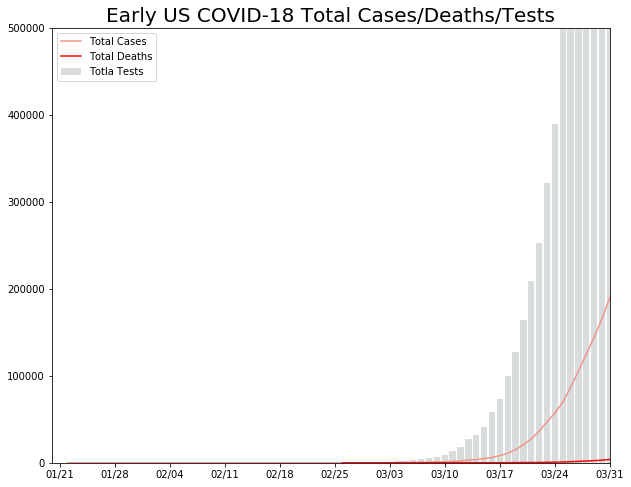

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(ctp_us_hist_plot_df.index, 
        ctp_us_hist_plot_df['test'], 
        alpha=0.5, 
        label='US Test', 
        color='#B2BABB',)

ax.plot(
    ctp_us_hist_plot_df['positive'],
    label='US Cases',
    color='#F1948A',
)

ax.plot(
    ctp_us_hist_plot_df['death'],
    label='US Cases',
    color='red',
)

# Set titles
ax.set_title('Early US COVID-18 Total Cases/Deaths/Tests', fontdict={'size':20})

# Set legends
ax.legend(['Total Cases', 'Total Deaths', 'Totla Tests'], loc='upper left')

# Set axes limit
start_date = datetime.datetime(2020, 1, 20)
end_date = datetime.datetime(2020, 3, 31)
ax.set_xlim(start_date, end_date)
ax.set_ylim(0, 500000)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

### US States Confirmed Cases Choropleth Map using `us_cov19_states_now_gdf` ([Ref1](https://towardsdatascience.com/a-beginners-guide-to-create-a-cloropleth-map-in-python-using-geopandas-and-matplotlib-9cc4175ab630) & [Ref2](https://geopandas.org/mapping.html))

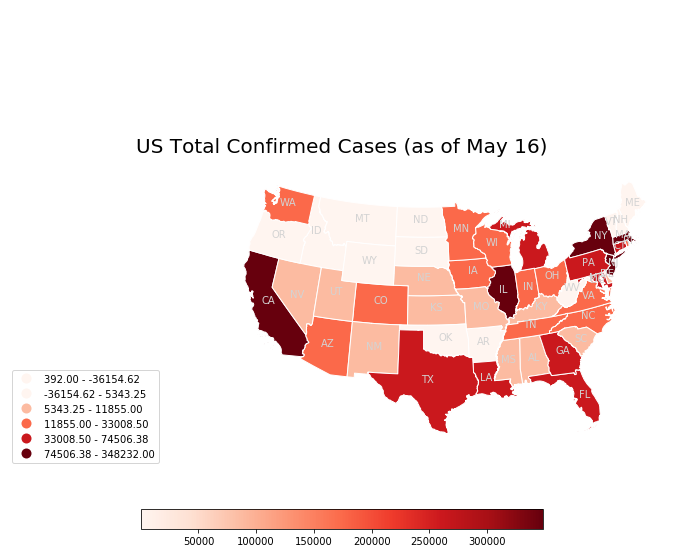

In [20]:
fig, ax = plt.subplots(figsize=(12,15))

# Normalize the Legend Color and create the legend bar
vmin, vmax = us_cov19_states_now_gdf.positive.min(), us_cov19_states_now_gdf.positive.max()
legend_bar = plt.cm.ScalarMappable(
     norm=plt.Normalize(vmin=vmin, vmax=vmax), 
     cmap='Reds')

us_cov19_states_now_gdf.plot(
    ax=ax,
    column='positive',
    cmap='Reds',
    edgecolor='white',
    legend=True,
    scheme= 'boxplot',
    legend_kwds={'loc': 'lower left'},
)

# Title  
today_date = datetime.datetime.now()
ax.set_title('US Total Confirmed Cases (as of ' + today_date.strftime('%b %d') + ')', fontdict={'size':20});

# Add the Color Legend Bar
fig.colorbar(legend_bar, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05, shrink=0.6)

# Displaying each State Postcode
for idx, row in us_cov19_states_now_gdf.iterrows():
    plt.annotate(s=row['state'], xy=row['coords'],
                 horizontalalignment='center',
                 color='lightgrey',
                )
    
# Turn off the box and the axes label
ax.axis(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Crop the map to an appropriate size (via coordinate)
# ax.set_ylim(-2500000, 4200000);  # shows alaska
ax.set_ylim(-2500000, 1000000);

# save the figure as a .png
# img_dir = 'Data/image/'
# filepath = os.path.join(img_dir + 'us_cases_choro_basic.png')
# fig.savefig(filepath, dpi=300, bbox_inches='tight')

### Choropleth map of the US State Total Confirmed Cases with a Hover Info using `plotly.graph_objects`</br>([Ref1](https://plotly.com/python/choropleth-maps/) & [Ref2](https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu))

In [23]:
# color scheme for the map plot (white to red)
color_scale = ['#ffffff', '#ffe6e6', '#ffcccc', '#ffb3b3', '#ff9999', '#ff8080', '#ff6666', '#ff4d4d', '#ff3333',
               '#ff1a1a', '#ff0000', '#e60000', '#cc0000', '#b30000', '#990000', '#800000', '#660000', '#4d0000']

# creating a new column that will include the mouse-hovering text for each state
for col in us_cov19_states_now_df.columns:
    us_cov19_states_now_df[col] = us_cov19_states_now_df[col].astype(str)

us_cov19_states_now_df['text'] = us_cov19_states_now_df['NAME'] + '<br>' + \
                                 'Deaths: ' + us_cov19_states_now_df['death'] + '<br>' + \
                                 'Tests: ' + us_cov19_states_now_df['test']

us_cov19_states_now_df[['positive', 'death', 'test']] = us_cov19_states_now_df[['positive', 'death', 'test']].apply(pd.to_numeric)

zmax = us_cov19_states_now_df['positive'].max()
zmid = us_cov19_states_now_df['positive'].median()
zmin = us_cov19_states_now_df['positive'].min()

fig = go.Figure(data=go.Choropleth(
    locations=us_cov19_states_now_df['state'],   # for county -> FIPS, for State -> post code, for Country -> ISO Code
    z = us_cov19_states_now_df['positive'],      # the column to color-code
    locationmode = 'USA-states',
    zmax = zmax, zmid = zmid, zmin = zmin,
    colorscale = color_scale, # 'YlOrRd',
    autocolorscale = False,
    text = us_cov19_states_now_df['text'],       # hover text
    marker_line_color = 'white',                 # for the lines separating states
    marker_line_width = 2,    
    colorbar_title = 'Confirmed Cases'
))

# updating the layout
fig.update_layout(
    title_text = 'US State COVID-19 Confirmed Cases (latest update: ' + today_date.strftime('%b %d') + ')',
    geo = dict(
            scope = 'usa',
            projection=go.layout.geo.Projection(type='albers usa'),
    )
)

fig.show()

In [24]:
fig.write_html('Data/output/us_state_latest.html')

#### View the map HERE: https://katkim0307.github.io/COVID-19_Response_Comparison//Data/output/us_state_latest.html

### Choropleth map of the US State Total Confirmed Cases with a Time Slidebar using `plotly.express`

In [27]:
ctp_states_hist_df = ctp_states_hist_df.sort_values(by=['date'])

color_scale = ['#ffffff', '#ffe6e6', '#ffcccc', '#ffb3b3', '#ff9999', '#ff8080', '#ff6666', '#ff4d4d', '#ff3333',
               '#ff1a1a', '#ff0000', '#e60000', '#cc0000', '#b30000', '#990000', '#800000', '#660000', '#4d0000']

fig = px.choropleth(
    ctp_states_hist_df,
    color='positive',
    locations='state',             
    locationmode = 'USA-states',
    scope='usa',
    hover_name='state',
    hover_data=['test', 'death'],
    animation_frame='date',
    title="Daily New COVID-19 Confirmed Cases",
    color_continuous_scale= color_scale, 
)

# This creates a slider for date that can be manually toggled.
fig['layout'].pop('updatemenus')

fig.show()

In [28]:
fig.write_html('Data/output/us_state_history.html')

#### View the Map HERE: https://katkim0307.github.io/COVID-19_Response_Comparison//Data/output/us_state_history.html

### US Counties Confirmed Cases Choropleth Map using `jhu_county_df` and `plotly.figure_factory` ([Ref1](https://towardsdatascience.com/interactive-covid-19-visualizations-using-plotly-with-4-lines-of-code-fa33b334ab84) & [Ref2](https://plotly.github.io/plotly.py-docs/generated/plotly.figure_factory.html))

In [29]:
# Declaring a DataFrame that copies rows from another jhu_county_df3 that has the latest date attribute
jhu_county_latest_df = (jhu_county_df[jhu_county_df['datetime'] == jhu_county_df.iloc[-1]['datetime']])

color_scale = ['#ffffff', '#ffe6e6', '#ffcccc', '#ffb3b3', '#ff9999', '#ff8080', '#ff6666', '#ff4d4d', '#ff3333',
               '#ff1a1a', '#ff0000', '#e60000', '#cc0000', '#b30000', '#990000', '#800000', '#660000', '#4d0000']

quantiles = list(jhu_county_latest_df['Cases'].quantile([0.1, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]))
fips = jhu_county_latest_df['FIPS'].tolist()
values = jhu_county_latest_df['Cases'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values, 
    scope=['usa'],
    binning_endpoints=quantiles,
    colorscale=color_scale,
    show_state_data=False,
    show_hover=True,
    county_outline=dict(color='white', width=0.25),
    asp = 2.9, 
    title_text = 'US State COVID-19 Confirmed Cases (latest update: ' + today_date.strftime('%b %d') + ')',
    legend_title = 'confirmed cases'
)

fig.layout.template = None

fig.show()


C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\plotly\figure_factory\_county_choropleth.py:845: UserWarning:

Unrecognized FIPS Values

Whoops! It looks like you are trying to pass at least one FIPS value that is not in our shapefile of FIPS and data for the counties. Your choropleth will still show up but these counties cannot be shown.
Unrecognized FIPS are: [80004, 80002, 80001, 80005, 80006, 80009, 90047, 90046, 90045, 90044, 90042, 90041, 90040, 90039, 90038, 90037, 90036, 90035, 90048, 90034, 90032, 90031, 90030, 90029, 90028, 90027, 90026, 90025, 90024, 90023, 90022, 90021, 90033, 90049, 90050, 90051, 99999, 90056, 90055, 90054, 90053, 90020, 90019, 90018, 90017, 80037, 80036, 80035, 80034, 80033, 80032, 80031, 80030, 80029, 80028, 80027, 80026, 80025, 80024, 80023, 80022, 80021, 80020, 80019, 80018, 80017, 80016, 80015, 80013, 80012, 80011, 80010, 80038, 80008, 80039, 80041, 90016, 90015, 90013, 90012, 90011, 90010, 90009, 90008, 90006, 90005, 90004, 90002, 90001, 88888, 8

In [30]:
fig.write_html('Data/output/us_county_latest.html')

#### View the Map HERE: https://katkim0307.github.io/COVID-19_Response_Comparison//Data/output/us_county_latest.html

# South Korea COVID-19 Case Data Visualisation
## Procedure 1: South Korea Provinces and Special/Metropolitan Cities GeoDataFrame (EPSG: 4326)

In [31]:
# Read in Natural Earth Large Scale Cultural Data (Admin 1 - States and Provinces) Boundary Shapefile
ne_admin_1_states_gdf = gpd.read_file('Data/input/ne_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

# Create a GeoDataFrame for South Korea Provinces & Special/Metropolitan Cities ONLY
kor_provinces_gdf=ne_admin_1_states_gdf[ne_admin_1_states_gdf['admin']=='South Korea']

# Keep the only columns that needed
kor_provinces_gdf = kor_provinces_gdf[['geonunit', 'gu_a3', 'gn_name', 'name_de', 'fips', 'latitude', 'longitude', 'geometry']]

# Adding a column 'coords' for later use (labeling each Province)
kor_provinces_gdf['coords'] = kor_provinces_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
kor_provinces_gdf['coords'] = [coords[0] for coords in kor_provinces_gdf['coords']]


## Procedure 2: South Korea COVID-19 Cases/Deaths/Testing DataFrame
### [South Korea Latest Update by Province](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_no_airport_xls.xlsx?raw=true)

In [32]:
# Read in the data
kor_province_now_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                            sheet_name='covid_19_update')

kor_province_now_df.fillna(0, inplace=True)

### [South Korea History Data](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_no_airport_xls.xlsx?raw=true)

In [33]:
# Read in the data
kor_hist_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                            sheet_name='covid_19_daily_country')

kor_hist_df.fillna(0, inplace=True)
kor_hist_df['datetime'] = kor_hist_df['Date'].copy()
kor_hist_df['Date']=kor_hist_df['Date'].astype(str)

# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_hist_plot_df = kor_hist_df[['datetime', 'Date', 'Confirm_New', 'Confirm_Tot', 'Death_New', 'Death_Tot', 
                                'Test_New', 'Test_Tot', 'Test_Curr']].copy()
kor_hist_plot_df.set_index('datetime', inplace=True)

### [South Korea Provinces and Special/Metropolitan Cities Data](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_xls.xlsx)

In [34]:
# Read in the data
kor_province_hist_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                                      sheet_name='covid_19_daily_province')

# Converting the Dtype of 'Date' to datetime
kor_province_hist_df['datetime'] = kor_province_hist_df['Date'].copy()
kor_province_hist_df['Date']=kor_province_hist_df['Date'].astype(str)

kor_province_hist_df.update(kor_province_hist_df[['Confirm_New', 'Confirm_Tot', 'Death_New', 'Death_Tot']].fillna(0))

# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_province_hist_plot_df = kor_province_hist_df[['datetime', 'Date', 'Province', 'Confirm_New', 'Confirm_Tot', 
                                                  'Death_New', 'Death_Tot', 'Test_New', 'Test_Tot', 'Test_Curr']].copy()
kor_province_hist_plot_df.set_index('datetime', inplace=True)

## Procedure 3: Merge South Korea COVID-19 DataFrame with Province GeoDataFrame 
### `kor_province_now_df` & `kor_provinces_gdf`

In [35]:
kor_cov19_province_now_merged_df = pd.merge(
    kor_province_now_df,
    kor_provinces_gdf[['geonunit', 'name_de', 'fips', 'latitude', 'longitude', 'geometry', 'coords']],
    left_on='Province',
    right_on='name_de',
    how='left',
)

kor_cov19_province_now_merged_df = kor_cov19_province_now_merged_df.drop(['name_de'], axis=1)

kor_cov19_province_now_gdf = gpd.GeoDataFrame(kor_cov19_province_now_merged_df, 
                                              crs={'init': 'epsg:4326'},
                                              geometry='geometry')

### `kor_province_hist_df` & `kor_provinces_gdf`

In [36]:
kor_cov19_province_hist_merged_df = pd.merge(
    kor_province_hist_df,
    kor_provinces_gdf[['geonunit', 'name_de', 'fips', 'latitude', 'longitude', 'geometry', 'coords']],
    left_on='Province',
    right_on='name_de',
    how='left',
)

kor_cov19_province_hist_merged_df = kor_cov19_province_hist_merged_df.drop(['name_de'], axis=1)

kor_cov19_province_hist_gdf = gpd.GeoDataFrame(kor_cov19_province_hist_merged_df, 
                                          crs={'init': 'epsg:4326'},
                                          geometry='geometry')

# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_province_hist_plot_gdf = kor_cov19_province_hist_gdf.copy()
kor_cov19_province_hist_plot_gdf.set_index('datetime', inplace=True)

## Procedure 4: South Korea COVID-19 Data Visualisation
### South Korea Latest Confirmed Cases Choropleth Map - `kor_cov19_province_now_gdf` ([Ref1](https://geopandas.org/mapping.html) & [Ref2](https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac))

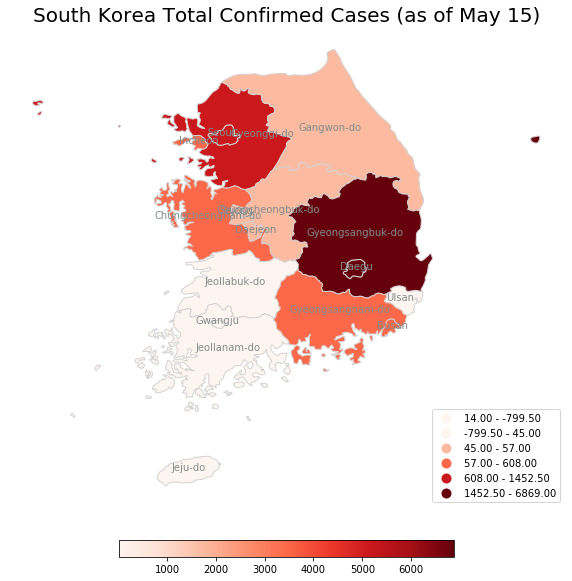

In [37]:
fig, ax = plt.subplots(figsize=(10,15))

# Normalize the Legend Color and create the legend bar
vmin, vmax = kor_cov19_province_now_gdf.Confirm_Tot.min(), kor_cov19_province_hist_plot_gdf.Confirm_Tot.max()
legend_bar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Reds')

# Plot
kor_cov19_province_now_gdf.plot(
    ax=ax,
    column='Confirm_Tot',
    cmap='Reds',
    edgecolor='lightgrey',
    legend=True,
    scheme='boxplot', 
    legend_kwds={'loc': 'lower right'},
)

# Title  
kor_update = kor_province_now_df.iloc[-1]['Date'].to_pydatetime()
ax.set_title('South Korea Total Confirmed Cases (as of ' + kor_update.strftime('%b %d') + ')', fontdict={'size':20});

# Add the Color Legend Bar
fig.colorbar(legend_bar, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04, shrink=0.6)

# Displaying each State Postcode
for idx, row in kor_cov19_province_now_gdf.iterrows():
    plt.annotate(s=row['Province'], xy=row['coords'],
                 horizontalalignment='center',
                 color='#7F8C8D',
                )

# Turn off the box and the axes label
ax.axis(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# save the plot as a .png

plt.savefig('kor_latest_total_confirmed_cases_by_provinces.png', dpi=300,)

### South Korea Confirmed Cases History Choropleth Map using GIFS ([Ref](https://towardsdatascience.com/how-to-make-a-gif-map-using-python-geopandas-and-matplotlib-cd8827cefbc8))

In [40]:
kor_province_cases_df = kor_province_hist_df[['Date', 'Province', 'Confirm_Tot']]

kor_province_cases_df['Date'] = kor_province_cases_df['Date'].astype(str)

pivot_df = kor_province_cases_df.pivot(index='Province', columns='Date', values='Confirm_Tot')
pivot_df.fillna(0, inplace=True)

pivot_merged_df = pd.merge(
    pivot_df,
    kor_provinces_gdf[['name_de', 'fips', 'geometry']],
    left_on='Province',
    right_on='name_de',
    how='left',
    sort=False,
)

pivot_merged_df.rename(columns={'name_de':'Province'}, inplace=True)
pivot_merged_df = pivot_merged_df[['Province', 'fips', 'geometry'] + [col for col in pivot_merged_df if col not in ['Province', 'fips', 'geometry']]]
pivot_merged_df = pivot_merged_df.set_index('Province')

pivot_merged_gdf = gpd.GeoDataFrame(pivot_merged_df, 
                                    crs={'init': 'epsg:4326'},
                                    geometry='geometry')

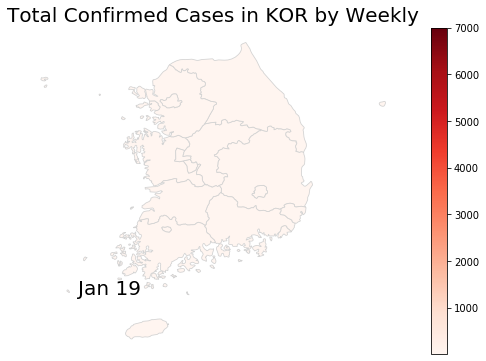

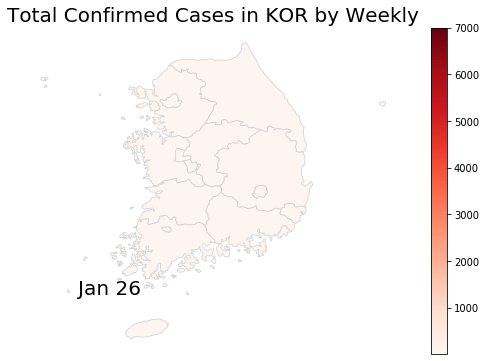

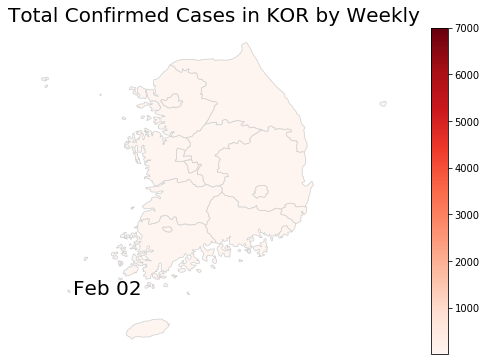

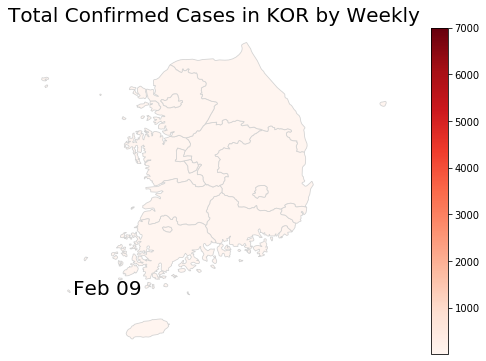

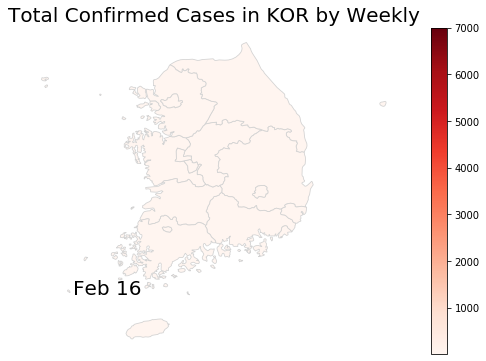

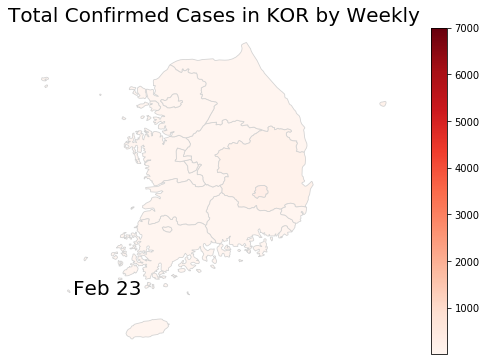

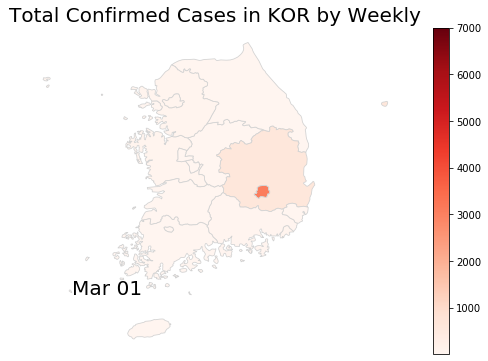

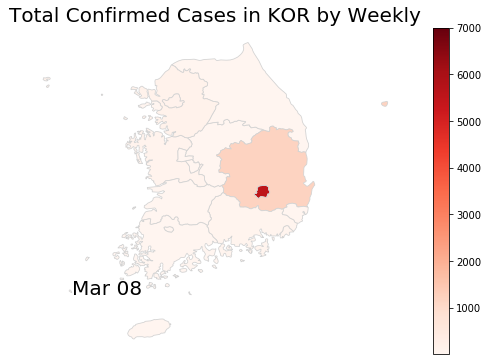

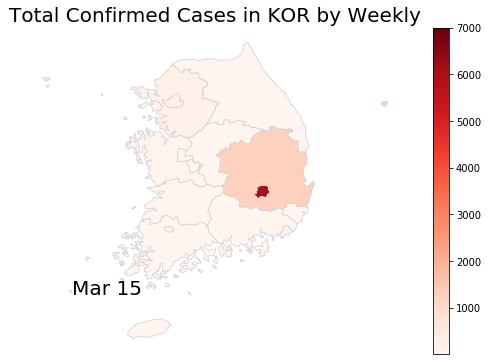

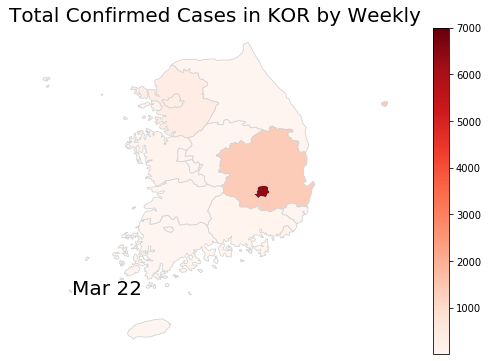

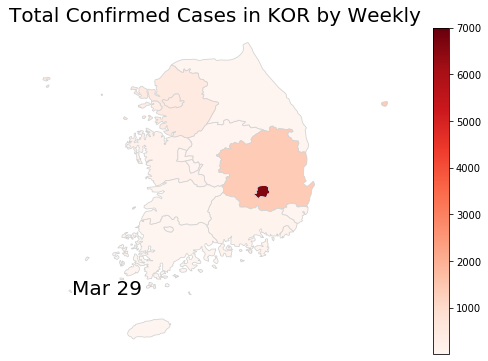

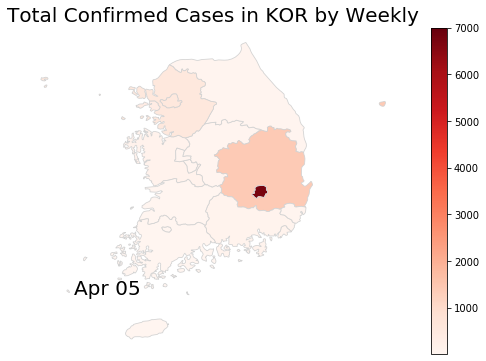

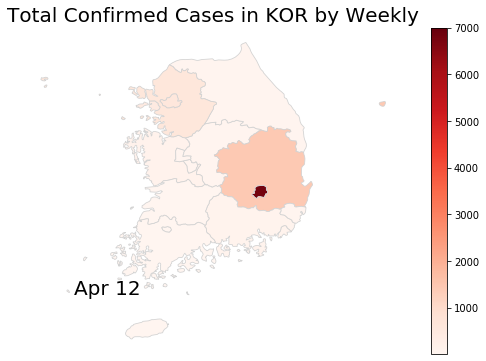

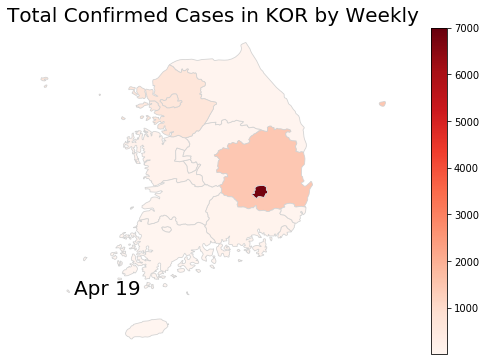

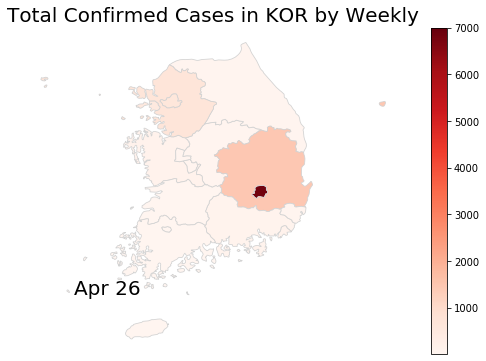

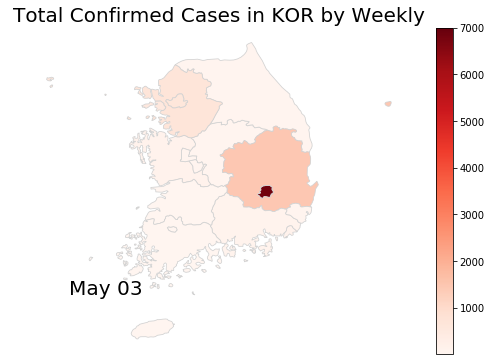

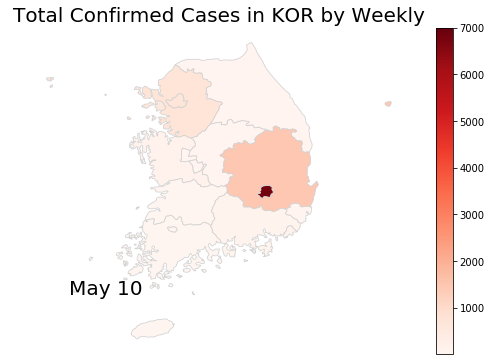

In [41]:
# path to save all images
output_path = 'Data/image/kor_province_gifs'

# counter for the loop
counter = 0

# list of dates
date_range_weekly = pd.date_range(start='2020-1-19', end='2020-5-10', freq='W').to_pydatetime().astype(str).tolist()
date_range_weekly = [date[:-9] for date in date_range_weekly]   # getting rid of time section of the date

# set the min and max range for the map
vmin, vmax = 10, 7000

# start the loop to create one map per date
for date in date_range_weekly:
    
    fig = pivot_merged_gdf.plot(column=date, cmap='Reds', figsize=(10, 6), 
                                linewidth=0.8, edgecolor='lightgrey', legend=True, 
                                vmin=vmin, vmax=vmax, norm=plt.Normalize(vmin=vmin, vmax=vmax))
                                # plt.Normalize will keep the legend range the same for all maps
    
    # remove axis of the chart
    fig.axis('off')
    
    # title
    fig.set_title('Total Confirmed Cases in KOR by Weekly', fontdict={'fontsize': '20', 'fontweight': '3'})
    
    # create an annotation for the week: changing the format of the date
    d = pd.to_datetime(date).strftime('%b %d, %Y')
    f = pd.to_datetime(date).strftime('%Y_%m_%d')
    only_md = d[:-6]  # so it doesn't show the year
    
    # position the annotation to the bottom right
    fig.annotate(only_md, xy=(0.29, 0.225), xycoords='figure fraction', 
                 horizontalalignment='right', verticalalignment='top', fontsize=20)
    
    # save each figure
    filepath = os.path.join(output_path, f+'_confirmed_cases.png')
    choromap = fig.get_figure()
    choromap.savefig(filepath, dpi=300)

### South Korea COVID-19 Cases History Line Graph - `kor_hist_plot_df` where the index = `datetime`

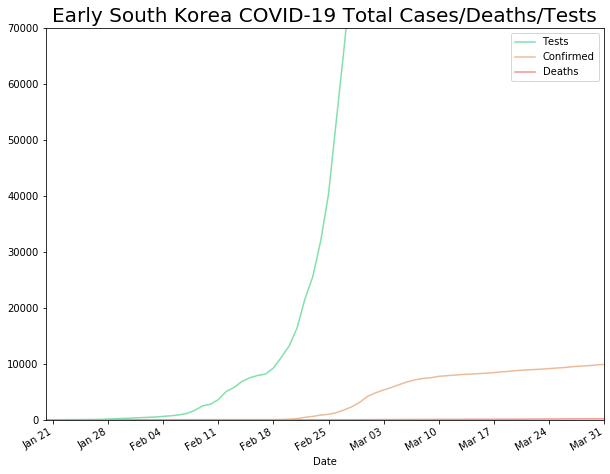

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

kor_hist_plot_df.plot(
    ax=ax,
    y=['Test_Tot', 'Confirm_Tot', 'Death_Tot'],
    xlim=('2020-01-20', '2020-03-31'),
    ylim=(0, 70000),
    color=['#82E0AA', '#EDBB99', '#F1948A'],
);

# Title
ax.set_title('Early South Korea COVID-19 Total Cases/Deaths/Tests', fontdict={'size':20});

# x-axis label
plt.xlabel('Date')

# Rename legend
ax.legend(['Tests', 'Confirmed', 'Deaths'])

# set ticks every month
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### South Korea COVID-19 Cases History - Overlaid Bar & Line Chart `kor_hist_plot_df`

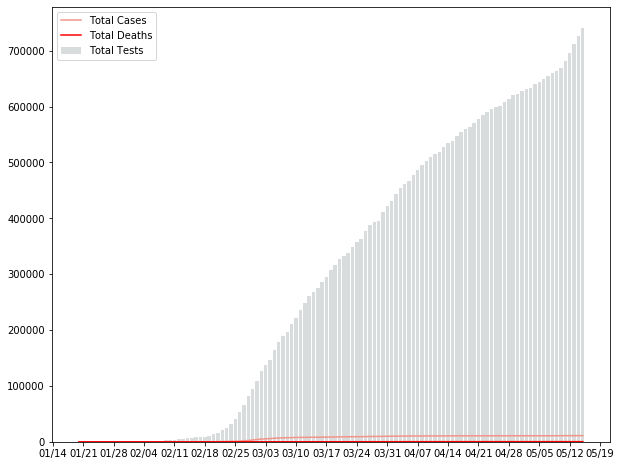

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(
    kor_hist_plot_df.index,
    kor_hist_plot_df['Test_Tot'], 
    alpha=0.5, 
    label='KOR Test', 
    color='#B2BABB',)

ax.plot(
    kor_hist_plot_df['Confirm_Tot'],
    label='KOR Cases',
    color='#F1948A',
)

ax.plot(
    kor_hist_plot_df['Death_Tot'],
    label='KOR Deaths',
    color='red',

)

ax.legend(['Total Cases', 'Total Deaths', 'Total Tests'])

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# US vs. South Korea COVID-19 Total Cases & Tests Comparison
### Overlaid Line Graph of Total Cases and Tests ([Ref](https://stackoverflow.com/questions/45574099/plot-different-columns-of-different-dataframe-in-the-same-plot-with-pandas))

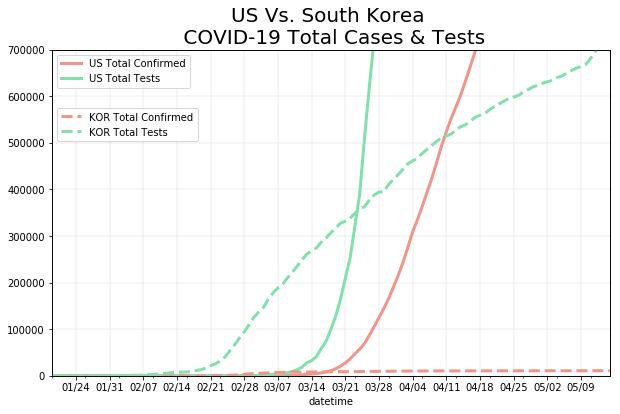

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()

ctp_us_hist_plot_df.plot(
    ax=ax,
    y=['positive', 'test'],
    color=['#F1948A', '#82E0AA'],
    linewidth=3,
    ylim=(0, 700000),
)

kor_hist_plot_df.plot(
    ax=ax2,
    ls='--',
    y=['Confirm_Tot', 'Test_Tot'],
    color=['#F1948A', '#82E0AA'],
    linewidth=3,
    ylim=(0, 700000),
)

ax.legend(['US Total Confirmed', 'US Total Tests'], loc='upper left')
ax2.legend(['KOR Total Confirmed', 'KOR Total Tests'], loc=(0.01, 0.72))

ax2.get_yaxis().set_visible(False)

ax.grid(linewidth=0.2)

ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_title('US Vs. South Korea \n COVID-19 Total Cases & Tests', fontdict={'size':20});

#plt.savefig('us_vs_kor_overlaid_line_graph.png', dpi=300)

plt.show()

### Line Graph Comparison of Total Cases per Million and Total Tests per Thousand

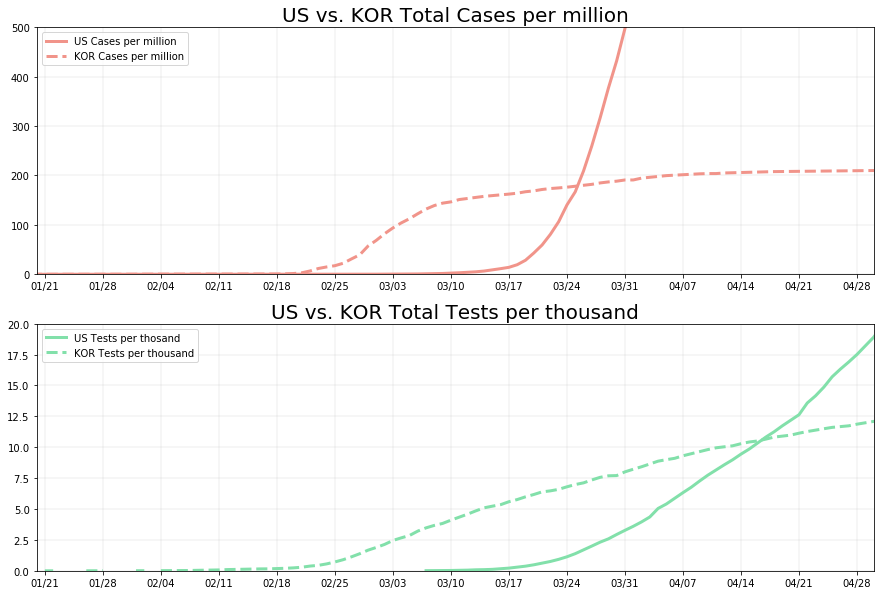

In [45]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(owid_us_plot_df['total_cases_per_million'], label='US Cases per mill', color='#F1948A', linewidth=3)
ax1.plot(owid_kor_plot_df['total_cases_per_million'], label='KOR Cases per mill', color='#F1948A', linewidth=3, ls='--')

ax2.plot(owid_us_plot_df['total_tests_per_thousand'], label='US Tests per 1000', color='#82E0AA', linewidth=3)
ax2.plot(owid_kor_plot_df['total_tests_per_thousand'], label='KOR Tests per 1000', color='#82E0AA', linewidth=3, ls='--')

# Set titles
ax1.set_title('US vs. KOR Total Cases per million', fontdict={'size':20})
ax2.set_title('US vs. KOR Total Tests per thousand', fontdict={'size':20})

# Set legends
ax1.legend(['US Cases per million', 'KOR Cases per million'], loc='upper left')
ax2.legend(['US Tests per thosand', 'KOR Tests per thousand'], loc='upper left')

# Set axes limit
start_date = datetime.datetime(2020, 1, 20)
end_date = datetime.datetime(2020, 4, 30)
ax1.set_xlim(start_date, end_date)
ax2.set_xlim(start_date, end_date)
ax1.set_ylim(0, 500)
ax2.set_ylim(0, 20)

# Set grid lines
ax1.grid(linewidth=0.2)
ax2.grid(linewidth=0.2)

#set ticks every week
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# #set major ticks format
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

### Line Graph Comparison `covtrack_us_hist_plot_df` & `kor_hist_plot_df`

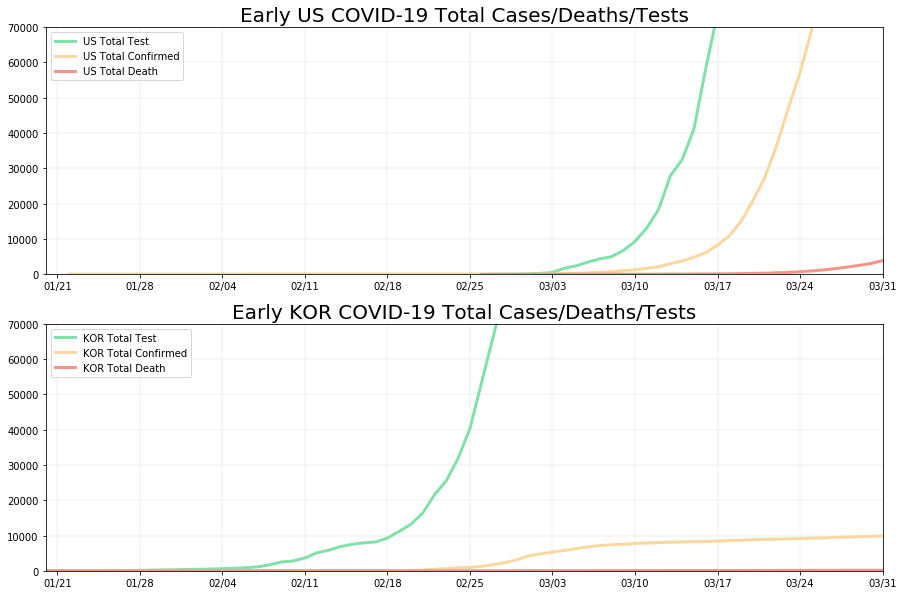

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(ctp_us_hist_plot_df['test'], label='US Tests', color='#82E0AA', linewidth=3)
ax1.plot(ctp_us_hist_plot_df['positive'], label='US Cases', color='#FAD7A0', linewidth=3)
ax1.plot(ctp_us_hist_plot_df['death'], label='US Deaths', color='#F1948A', linewidth=3)

ax2.plot(kor_hist_plot_df['Test_Tot'], label='KOR Tests', color='#82E0AA', linewidth=3)
ax2.plot(kor_hist_plot_df['Confirm_Tot'], label='KOR Cases', color='#FAD7A0', linewidth=3)
ax2.plot(kor_hist_plot_df['Death_Tot'], label='KOR Deaths', color='#F1948A', linewidth=3)

# Set titles
ax1.set_title('Early US COVID-19 Total Cases/Deaths/Tests', fontdict={'size':20})
ax2.set_title('Early KOR COVID-19 Total Cases/Deaths/Tests', fontdict={'size':20})

# Set legends
ax1.legend(['US Total Test', 'US Total Confirmed', 'US Total Death'], loc='upper left')
ax2.legend(['KOR Total Test', 'KOR Total Confirmed', 'KOR Total Death'], loc='upper left')

# Set axes limit
start_date = datetime.datetime(2020, 1, 20)
end_date = datetime.datetime(2020, 3, 31)
ax1.set_xlim(start_date, end_date)
ax2.set_xlim(start_date, end_date)
ax1.set_ylim(0, 70000)
ax2.set_ylim(0, 70000)

# Set grid lines
ax1.grid(linewidth=0.2)
ax2.grid(linewidth=0.2)

#set ticks every week
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# #set major ticks format
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

#plt.savefig('us_vs_kor_early_line_graph_compare.png', dpi=300)

### Bar & Line Graph Comparison ([Ref1](https://plotly.com/python/histograms/) & [Ref2](https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html))

### overlaid (Stacked) Bar & Line Graph Comparison ([Ref1](https://plotly.com/python/histograms/) & [Ref2](https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html))

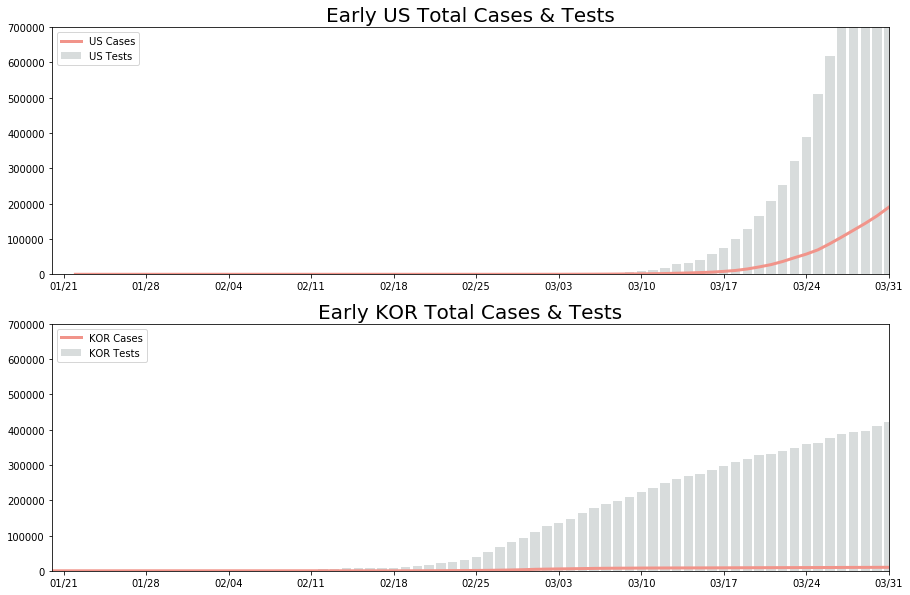

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.bar(ctp_us_hist_plot_df.index, 
        ctp_us_hist_plot_df['test'], 
        alpha=0.5, 
        label='US Test', 
        color='#B2BABB',)

ax1.plot(
    ctp_us_hist_plot_df['positive'],
    label='US Cases',
    color='#F1948A',
    linewidth=3,
)

ax2.bar(kor_hist_plot_df.index, 
        kor_hist_plot_df['Test_Tot'], 
        alpha=0.5, 
        label='KOR Test', 
        color='#B2BABB',
       )

ax2.plot(
    kor_hist_plot_df['Confirm_Tot'],
    label='KOR Cases',
    color='#F1948A',
    linewidth=3,
)

# Set titles
ax1.set_title('Early US Total Cases & Tests', fontdict={'size':20})
ax2.set_title('Early KOR Total Cases & Tests', fontdict={'size':20})

# Set legends
ax1.legend(['US Cases', 'US Tests'], loc='upper left')
ax2.legend(['KOR Cases', 'KOR Tests'], loc='upper left')

# Set axes limit
start_date = datetime.datetime(2020, 1, 20)
end_date = datetime.datetime(2020, 3, 31)
ax1.set_xlim(start_date, end_date)
ax2.set_xlim(start_date, end_date)
ax1.set_ylim(0, 700000)
ax2.set_ylim(0, 700000)

#set ticks every week
ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

#set major ticks format
ax2.xaxis.set_major_locator(mdates.WeekdayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

#plt.savefig('us_vs_kor_early_bar_line_graph_compare.png', dpi=300)

### Overlaid (Stacked) Bar & Line Graph Comparison ([Ref1](https://plotly.com/python/histograms/) & [Ref2](https://scentellegher.github.io/programming/2017/05/24/pandas-bar-plot-with-formatted-dates.html))

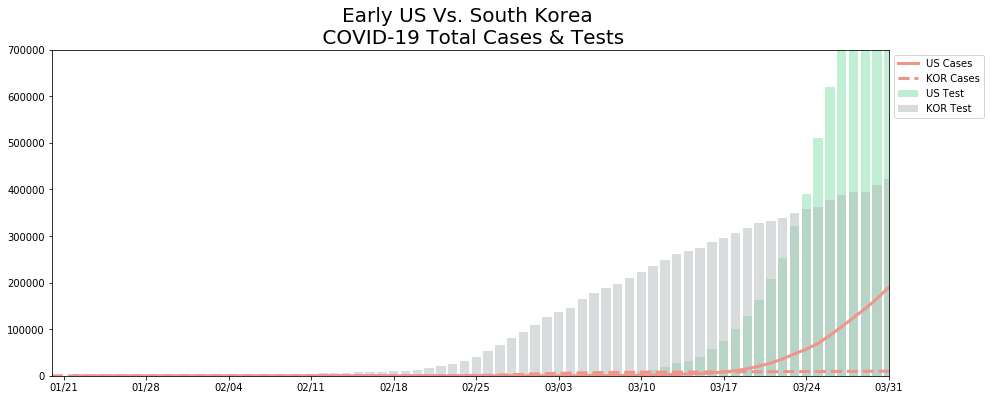

In [48]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(ctp_us_hist_plot_df.index, 
       ctp_us_hist_plot_df['test'], 
       alpha=0.5, label='US Test', 
       color='#82E0AA',
)

ax.bar(kor_hist_plot_df.index, 
        kor_hist_plot_df['Test_Tot'], 
        alpha=0.5, 
        label='KOR Test', 
        color='#B2BABB',
)

ax.plot(
    ctp_us_hist_plot_df['positive'],
    label='US Cases',
    color='#F1948A',
    linewidth=3,
)

ax.plot(
    kor_hist_plot_df['Confirm_Tot'],
    label='KOR Cases',
    ls='--',
    color='#F1948A',
    linewidth=3,
)

# set the range of axes
start_date = datetime.datetime(2020, 1, 20)
end_date = datetime.datetime(2020, 3, 31)
ax.set_xlim(start_date, end_date)
ax.set_ylim(0, 700000)

# set the legend location
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

plt.title('Early US Vs. South Korea \n COVID-19 Total Cases & Tests', 
          fontdict={'size':20});

#plt.savefig('us_vs_kor_early_overlaid_bar_line_graph.png', dpi=300)

### Overlaid Histogram of Overall US vs. KOR

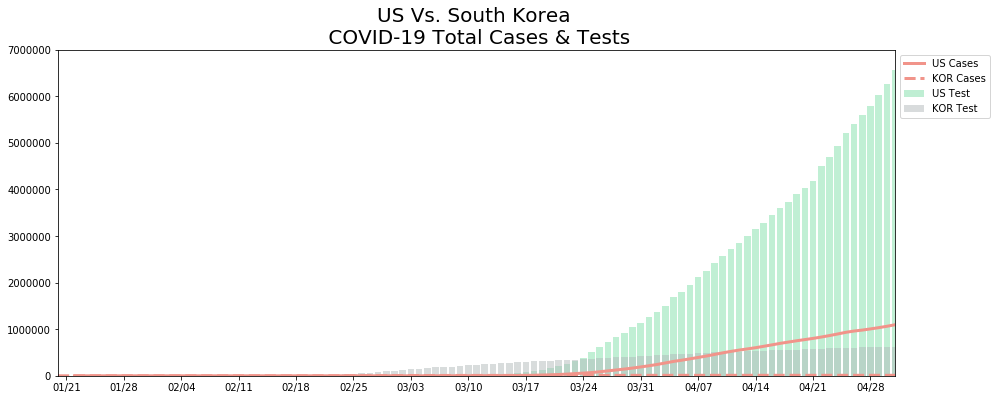

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(ctp_us_hist_plot_df.index, 
       ctp_us_hist_plot_df['test'], 
       alpha=0.5, label='US Test', 
       color='#82E0AA',
      )

ax.bar(kor_hist_plot_df.index, 
        kor_hist_plot_df['Test_Tot'], 
        alpha=0.5, 
        label='KOR Test', 
        color='#B2BABB',
       )

ax.plot(
    ctp_us_hist_plot_df['positive'],
    label='US Cases',
    color='#F1948A',
    linewidth=3,
)

ax.plot(
    kor_hist_plot_df['Confirm_Tot'],
    label='KOR Cases',
    ls='--',
    color='#F1948A',
    linewidth=3,
)
# Title
ax.set_title('US Vs. South Korea \n COVID-19 Total Cases & Tests', fontdict={'size':20});

# set the range of axes
start_date = datetime.datetime(2020, 1, 20)
end_date = datetime.datetime(2020, 5, 1)
ax.set_xlim(start_date, end_date)
ax.set_ylim(0, 7000000)

# set the legend location
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

#plt.savefig('us_vs_kor_overlaid_bar_line_graph.png', dpi=300,)